# Modelos de predicción de fuga de clientes
### Álvaro León Garrido

# Introducción
##### El ejercicio consiste en la construcción de un modelo de clasificación de clientes para predecir aquellos que potencialmente se irán de un compañia de telecomunicaciones. Para ello se dispone de una serie de variables que describen el comportamiento "tecnológico" de los clientes respecto a los servicios y canales de atención de la compañia. El ejercicio consiste, en primer término, en construir un tablón analítico que reuna y organice coherentemente la información para dos meses consecutivos. Con ello debe realizarse, luego, una exploración de la calidad de los datos, y prepararlos para utilizarlos en el modelo de clasificación. Más tarde, tras generar un modelo base, se deben realizar esfuerzos para optimizar features y/o parámetros del modelo. Finalmente, se describirán las características del modelo en relación a su propósito.

# Preambulo
##### En primer lugar debemos cargar las librerías a utilizar en el ejercicio, y los datos con los que contamos. Luego, haremos una pequeña descripción de estos para comenzar a familiarizarnos con ellos. Así, tenemos lo siguiente:

In [335]:
# Cargamos librerías
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import naive_bayes
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from pandas.plotting import scatter_matrix
from scipy import stats
from bs4 import BeautifulSoup
from matplotlib import pyplot

In [336]:
# Cargamos datos de diciembre
dic_clientes = pd.read_csv('diciembre/clientes_diciembre.csv', sep = '|')
dic_productos = pd.read_csv('diciembre/productos_diciembre.csv', sep = '|')
dic_consumos = pd.read_csv('diciembre/consumos_diciembre.csv', sep = '|')
dic_financiacion = pd.read_csv('diciembre/financiacion_diciembre.csv', sep = '|')

In [337]:
# Cargamos datos de diciembre
ene_clientes = pd.read_csv('enero/clientes_enero.csv', sep = '|')
ene_productos = pd.read_csv('enero/productos_enero.csv', sep = '|')
ene_consumos = pd.read_csv('enero/consumos_enero.csv', sep = '|')
ene_financiacion = pd.read_csv('enero/financiacion_enero.csv', sep = '|')

Contamos información de **95.467 registros/clientes en diciembre y 92.711 en enero**. Además del identificador, poseemos 18 descritores de cada uno de ellos. La variable objetivo o `target` se construirá posteriormente, determinando qué clientes (`id`) en diciembre han dejado de estarlo en enero. Así, `target` será simplemente una variable dicotómica donde 1 representa que el cliente se ha ido (presencia del atributo *fuga*) y 0 será que el cliente permaneción otro mes en la compañía.

Luego, los features sobre los clientes son los siguientes:

+ `id`: es el identificador unico de cada cliente (valores numéricos). 

> Descripción de los clientes:
+ `edad`: edad de los clientes (entre 18 a 85 años).
+ `facturacion`: dinero que pagan los clientes al mes (entre 15 y 400).
+ `antiguedad`: fecha de alta del cliente (*string*, casi valores únicos).
+ `provincia`: lugar de procedencia del cliente (50 provincias nombradas de España).
+ `num_lineas`: número de líneas móviles contratadas (entre 1 y 5).
+ `num_dt`: número de líneas en impago (numérica, de 1 a 4. `NaN` si no tiene en impago).
+ `incidencia`: si el cliente ha tenido alguna incidencia/reclamación (`NaN` si no lo ha hecho).

> Descripción de productos contratados:
+ `conexión`: tipo de conexión de internet del cliente (dos valores: `FIBRA` o `ADSL`).
+ `vel_conexion`: velocidad de conexión de internet (*string* que esconde numérica. 11 valores distintos).
+ `TV`: tipo de paquete de tv contratado por el cliente (3 valores distintos).

> Descripción del consumo de servicios:
+ `num_llamad_ent`: número de llamadas entrantes de todas sus líneas (numérica, entre 0 y 250).
+ `num_llamad_sal`: número de llamadas salientes de todas sus líneas (numérica, entre 0 y 100).
+ `mb_datos`: mb de los datos consumidos en todas sus líneas (numérica, entre 0 y 25.000).
+ `seg_llamad_ent`: segundos consumidos en llamadas entrantes (numérica, entre 0 y 20.000).
+ `seg_llamad_sal`: segundos consumidos en llamadas salientes (numérica, entre 0 y 20.000).

> Descripción del consumo de servicios:
+ `financiación`: si el cliente tiene financiado algún terminal (`NaN` si no lo tiene).
+ `imp_financ`: el dinero mensual que paga por los terminales financiados (`NaN` si no tiene terminal financiado).
+ `descuentos`: si el cliente tiene activo algún descuento (`NaN` si no tiene).

In [338]:
dic_clientes.shape[0]

95467

In [339]:
ene_clientes.shape[0]

92711

# EDA y depuración de los datos
##### En este apartado haremos realizaremos un análisis exploratorio de los datos para prepararlos con miras a un primer modelo de clasificación. Para ello, primero, los reuniremos según cada mes en un único dataset.

In [340]:
# Juntamos datos de diciembre
merge1 = pd.merge(dic_clientes, dic_productos, how='left', on='id')
merge2 = pd.merge(merge1, dic_consumos, how='left', on='id')
dic_raw = pd.merge(merge2, dic_financiacion, how='left', on='id')

# Juntamos datos de enero
merge3 = pd.merge(ene_clientes, ene_productos, how='left', on='id')
merge4 = pd.merge(merge3, ene_consumos, how='left', on='id')
ene_raw = pd.merge(merge4, ene_financiacion, how='left', on='id')

<br>A través de un simple `describe` podemos constatar que el conjunto de datos no tiene valores fuera de rango ni `NA`. No obstante, encontramos otros problemas que deben ser resueltos para construir un primer modelo base:

**(1) Incongruencia en el registro del dato de algunas features**. Por ejemplo, vimos que `num_dt`, que representa el número de líneas en impago es una varible numérica con valores entre 1 y 4. No obstante, si un cliente no tiene líneas en impago, en vez de ser expresado con un cero se ha dejado vacío, lo que es interpretado por `read_csv` de *pandas* como un *not a number* o `NaN`. Debemos corregir esto tanto en `num_dt` como en `incidencia`, `financiacion`, `imp_financ` y `descuentos`. Ahora bien, para las numéricas el valor real es 0, y para las categóricas también en la medida que sean realmente dicotómicas (si/no).

**(2) Mucha información en una misma variable**. La variable `antiguedad` en realidad aun no registra dicho fenómeno. Es simplemente la fecha y hora en que el cliente se dio de alta en la compañía. En ese sentido, la variable contiene mucha información para estar almacenada en una sola variable. Podemos, por ejemplo, **calcular la real antiguedad del cliente** (tomando como referencia la fecha más antigua, el último día del mes, o el primer día del mes siguiente); el **día de la semana en que se dio de alta**, o dividir el mes en semanas o quincenas; el **momento del día (AM o PM)** o incluso por tramos horarios. En definitiva, es una variable que puede dar bastante información.

El mismo fenómeno ocurre con la variable `provincia`. La información geográfica es en general muy valiosa. En este caso se reduce simplemente al nombre de la pronvincia de España en que el cliente se ha dado de alta. No obstante, para utilizarla debemos primero que todo convertirla a numérica. Luego, considerando información externa podemos potenciarla, con la complicación de que toda información externa debe corresponder al momento de referencia (diciembre de 2019 -No puede aportarse información ni mucho más nueva ni mucho más vieja), y bueno... que los datos son ficticios. Podemos, por ejemplo, **agregar información sociodemográfica** (cantidad de habitantes, proporción de hombres y mujeres, superficie) o alguna más **relacionada con el negocio** (poder de compra de los residentes -PIB percápita o alguna otra medida menos indirecta; competencia, o cantidad de compañías de telecomunicaciones, etc.). 

**(3) Variables categórica que esconde una numérica**. Esto ocurre en dos sentidos. `vel_conexion`, si bien posee una unidad de medida, al ser en todos los casos la misma, lo que realmente expresa es un número. Por otro lado, `conexion` y `TV`, al poseer pocos valores (2 y 3 respectivamente), en realidad pueden expresarse como variables *dummie*.

In [341]:
dic_raw.describe(include='all')

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,conexion,vel_conexion,TV,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos
count,95467.000000,95467.000000,95467.000000,95467,95467,95467.000000,6517.000000,5232,95467,95467,95467,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,6372,6372.000000,19154
unique,NaN,NaN,NaN,95171,50,NaN,NaN,1,2,11,3,NaN,NaN,NaN,NaN,NaN,1,NaN,1
top,NaN,NaN,NaN,08/05/2011 06:34 AM,Zaragoza,NaN,NaN,SI,ADSL,200MB,tv-futbol,NaN,NaN,NaN,NaN,NaN,SI,NaN,SI
freq,NaN,NaN,NaN,2,1991,NaN,NaN,5232,47900,9677,47535,NaN,NaN,NaN,NaN,NaN,6372,NaN,19154
mean,49994.256832,51.462086,207.392912,NaN,NaN,3.558518,2.498082,NaN,NaN,NaN,NaN,124.815633,50.022762,12489.795898,9984.406612,10029.761342,NaN,22.268613,NaN
std,28873.008865,19.590846,111.343491,NaN,NaN,1.086095,1.121339,NaN,NaN,NaN,NaN,72.492338,29.119904,7239.421267,5763.182070,5763.518604,NaN,10.177659,NaN
min,1.000000,18.000000,15.000439,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,5.009999,NaN
25%,24997.500000,35.000000,111.383822,NaN,NaN,3.000000,1.000000,NaN,NaN,NaN,NaN,62.000000,25.000000,6177.500000,5006.000000,5055.000000,NaN,13.432253,NaN
50%,49970.000000,51.000000,206.808431,NaN,NaN,4.000000,3.000000,NaN,NaN,NaN,NaN,124.000000,50.000000,12466.000000,9965.000000,10024.000000,NaN,21.885534,NaN
75%,75021.500000,68.000000,304.436599,NaN,NaN,4.000000,4.000000,NaN,NaN,NaN,NaN,188.000000,75.000000,18785.500000,14969.000000,15007.000000,NaN,31.155292,NaN


### Incongruencias por `NaN`
En este subapartado vamos a corregir los `NaN` del dataset para las variables categóricas (que expresan Sí/No, por tanto transformando a 1/0) y para las numéricas (simplemente reemplazando por 0).

In [342]:
# Convierto numéricas
dic_raw['num_dt'].fillna(0, inplace=True)

In [343]:
dic_raw['imp_financ'].fillna(0, inplace=True)

In [344]:
## Convierto categóricas
dic_raw['incidencia'].replace(('SI'), (1), inplace=True)
dic_raw['incidencia'].fillna(0, inplace=True)

dic_raw['financiacion'].replace(('SI'), (1), inplace=True)
dic_raw['financiacion'].fillna(0, inplace=True)

dic_raw['descuentos'].replace(('SI'), (1), inplace=True)
dic_raw['descuentos'].fillna(0, inplace=True)

### Variables con mucha información
En este subapartado vamos a transformar `antiguedad` y `provincia` en variables utilizables para el modelo (es decir, en numéricas o *date*).

**(1)** Variables de fecha y hora. Construiremos nuevas variables para registrar por separado el año, mes y día en que se ha dado de alta el cliente, más una variable que registra la antiguedad del cliente en días.

In [345]:
# Le damos formato fecha a la columna `antiguedad`
dic_raw['antiguedad'] = pd.to_datetime(dic_raw['antiguedad'], format='%m/%d/%Y %I:%M %p')

> Si inspeccionamos la nueva variable, vemos que la fecha/cliente más antiguo es el 1 de enero de 1995, y la más nueva o última el 31 de diciembre del 2019 (terminando el año).

In [346]:
dic_raw['antiguedad'].describe()

count                   95467
unique                  95171
top       2017-05-18 04:23:00
freq                        2
first     1995-01-01 15:23:00
last      2019-12-31 03:30:00
Name: antiguedad, dtype: object

In [347]:
# Creamos variables numéricas del año, mes y día de la semana en que se ha dado de alta el cliente
dic_raw['ano_alta'] = dic_raw['antiguedad'].dt.year
dic_raw['mes_alta'] = dic_raw['antiguedad'].dt.month
dic_raw['dia_alta'] = dic_raw['antiguedad'].dt.dayofweek

In [348]:
# Creamos el día de referencia para calcular antiguedad en días (1 de enero de 2020)
age = pd.to_datetime('2020-01-01')
# Calculamos la diferencia
dif = age - dic_raw['antiguedad']
# Extraémos solos los días en una nueva variable
dic_raw['fidelidad'] = dif.dt.days

**(2)** Provincia. Para el primer modelo base vamos a transformar automáticamente las categorías a números. En mejoras de modelo posiblemente hagamos cosas más intencionadas, de merecer la pena.

In [349]:
dic_raw['provincia'] = dic_raw['provincia'].astype('category')
dic_raw['provincia'] = dic_raw['provincia'].cat.codes

### Variables que esconden una numérica.
En este apartado vamos a transformar `conexion`, que tiene 2 valores (*FIBRA* y *ADSL*), a numérica con valores 1 y 0, respectivamente. Luego, `vel_conexion` la transformamos a numérica eliminando la parte "MB" del string. Finalmente, `TV` se transformará a dummie, dejando como referencia a 'tv-total', que es la menos frecuente.

In [350]:
pd.value_counts(dic_raw['TV'])

tv-futbol      47535
tv-familiar    33768
tv-total       14164
Name: TV, dtype: int64

**(1)** Conexión a dicotómica.

In [351]:
dic_raw['conexion'].replace(('FIBRA','ADSL'), (1,0), inplace=True)

**(2)** Velocidad de conexión.

In [352]:
dic_raw['vel_conexion'] = dic_raw['vel_conexion'].str.strip('MB')
dic_raw['vel_conexion'] = dic_raw['vel_conexion'].astype('int32')

**(3)** TV, o tipo de servicio de TV.

In [353]:
tv_dummies = pd.get_dummies(dic_raw['TV'])
dic_raw.insert(23, 'tv_familiar', tv_dummies['tv-familiar'])
dic_raw.insert(24, 'tv_futbol', tv_dummies['tv-futbol'])

#### Tras todas estas tranformaciones, ya tenemos un conjunto de datos depurado para realizar nuestro primer modelo de clasificación de clientes. Sólo resta construir la variable target, en el siguiente apartado.

# Construcción de *target*

En este apartado vamos a construir y agregar la variable target al dataset de diciembre, para construir nuestro modelo basal de clasficación. Para ello, creamos un dataset con los id de enero más una columna rellena de 0, que luego cruzamos con los los id de diciembre, manteniendo todos los datos de diciembre: nos interesa saber qué id de diciembre siguen en enero. Allí donde la union ponga un 0 son clientes que se mantienen; donde aparezcan NaN son clientes perdidos (esos los tranformamos a 1, como presencia del atributo "fuga"). Finalmente, agregamos la variable target a los datos depurados de diciembre para comenzar con el modelo base.

In [354]:
# Creo el dataset de clientes de enero
user_ene = pd.DataFrame(ene_raw['id'])
user_ene['target'] = 0

In [355]:
# Creamos la target, cruzando los id de diciembre con los de enero
target = pd.merge(dic_raw['id'], user_ene, how='left', on='id')
target['target'].fillna(1, inplace=True)

> Al inspeccionar el resultado de `target`, podemos ver que entre diciembre de 2019 y enero de 2020 la compañía ha perdido 7.085 clientes, lo que representa poco menos de un 8% de su cartera. El gráfico ulterior muestra que la distribución de clientes según su permanencia está desigualmente distribuida.

### Este dato es importantísimo para la construcción de la muestra de entrenamiento y testeo del modelo. En general, tenemos un porcentaje bastante menor de sucesos a detectar (valor 1 de target, fuga de clientes), por lo tendremos que tomar las medidas del caso para que el muestreo sea proporcional a dicha distribución.

In [356]:
pd.value_counts(target['target'])
# 7,4% dejan la compañía en enero 2020.

0.0    88382
1.0     7085
Name: target, dtype: int64

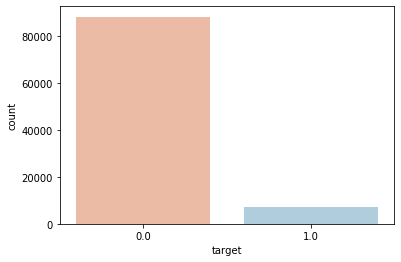

In [357]:
dist_target = sns.countplot(x='target', data=target, palette='RdBu')

### Dataset diciembre depurado.
Ahora creamos el dataset depurado que incorpora la `target` y eliminando la variable `antiguedad` que hemos utilizado para construir otras y `TV` que convertimos en *dummies*. Así, nuestro dataset final solo contiene features numeridos.

In [358]:
data_dic = dic_raw.copy(deep = True)
data_dic = pd.merge(data_dic, target, how='left', on='id')
del data_dic['antiguedad']
del data_dic['TV']
data_dic.describe(include='all')

,id,edad,facturacion,provincia,num_lineas,num_dt,incidencia,conexion,vel_conexion,num_llamad_ent,...,financiacion,imp_financ,descuentos,ano_alta,mes_alta,dia_alta,fidelidad,tv_familiar,tv_futbol,target
count,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,...,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000
mean,49994.256832,51.462086,207.392912,24.524328,3.558518,0.170530,0.054804,0.498256,136.517278,124.815633,...,0.066746,1.486331,0.200635,2006.976149,6.522589,3.001676,4573.466968,0.353714,0.497921,0.074214
std,28873.008865,19.590846,111.343491,14.453017,1.086095,0.694799,0.227599,0.500000,179.279833,72.492338,...,0.249582,6.148373,0.400477,7.194673,3.444165,1.997583,2630.422152,0.478124,0.499998,0.262120
min,1.000000,18.000000,15.000439,0.000000,1.000000,0.000000,0.000000,0.000000,10.000000,0.000000,...,0.000000,0.000000,0.000000,1995.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24997.500000,35.000000,111.383822,12.000000,3.000000,0.000000,0.000000,0.000000,20.000000,62.000000,...,0.000000,0.000000,0.000000,2001.000000,4.000000,1.000000,2309.000000,0.000000,0.000000,0.000000
50%,49970.000000,51.000000,206.808431,25.000000,4.000000,0.000000,0.000000,0.000000,35.000000,124.000000,...,0.000000,0.000000,0.000000,2007.000000,7.000000,3.000000,4587.000000,0.000000,0.000000,0.000000
75%,75021.500000,68.000000,304.436599,37.000000,4.000000,0.000000,0.000000,1.000000,200.000000,188.000000,...,0.000000,0.000000,0.000000,2013.000000,10.000000,5.000000,6851.000000,1.000000,1.000000,0.000000
max,100000.000000,85.000000,399.998433,49.000000,5.000000,4.000000,1.000000,1.000000,600.000000,250.000000,...,1.000000,39.990128,1.000000,2019.000000,12.000000,6.000000,9130.000000,1.000000,1.000000,1.000000


In [359]:
data_dic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95467 entries, 0 to 95466
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              95467 non-null  int64  
 1   edad            95467 non-null  int64  
 2   facturacion     95467 non-null  float64
 3   provincia       95467 non-null  int8   
 4   num_lineas      95467 non-null  int64  
 5   num_dt          95467 non-null  float64
 6   incidencia      95467 non-null  float64
 7   conexion        95467 non-null  int64  
 8   vel_conexion    95467 non-null  int32  
 9   num_llamad_ent  95467 non-null  int64  
 10  num_llamad_sal  95467 non-null  int64  
 11  mb_datos        95467 non-null  int64  
 12  seg_llamad_ent  95467 non-null  int64  
 13  seg_llamad_sal  95467 non-null  int64  
 14  financiacion    95467 non-null  float64
 15  imp_financ      95467 non-null  float64
 16  descuentos      95467 non-null  float64
 17  ano_alta        95467 non-null 

### Exploración del conjunto de datos.
Con objeto de explorar las interacciones entre las variables del conjunto de datos, en este último subapartado del EDA y depuración visualizaremos algunas relaciones entre variables con miras a describir cuáles podrían ser las variables más importantes para el modelo buscado.

En este sentido, los gráficos posteriores nos indican que serían muy pocas variables las que jugarían un papel importante en el modelo. Por ejemplo, algunas variables que discriminan respecto a la `target` podrían ser `fidelidad` (cantidad de días desde el alta del cliente), `mes_alta` y `ano_alta`. No obstante esta asociación no es muy clara.

Ahora bien, `incidencia` es un claro discriminador a la hora de clasificar a los clientes de diciembre: **alrededor de un 60% de los clientes que reportan incidencia dejaron la compañía en enero**. De igual modo, **el tener líneas impagas** también aumenta la probabilidad de dejar la compañía en un 60% (con independencia del número de líneas). Finalmente, podemos ver que la variable `descuento` es totalmente determinante: **el 100% de clientes que han dejado la compañía no tienen descuento**, o dicho de otra forma, si tienes descuento no dejas la compañía.

Con estos datos podemos interpretar de mejor manera el modelo base.

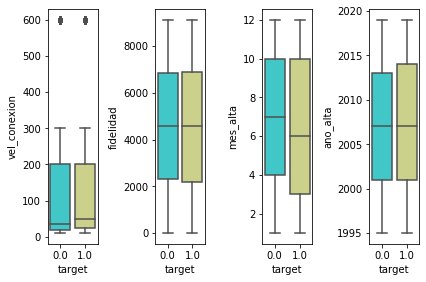

In [360]:
figure, axes = plt.subplots(nrows=1, ncols=4)
plt.subplot(1, 4, 1)
sns.boxplot(x='target', y='vel_conexion', data=data_dic, palette='rainbow')
plt.subplot(1, 4, 2)
sns.boxplot(x='target', y='fidelidad', data=data_dic, palette='rainbow')
plt.subplot(1, 4, 3)
sns.boxplot(x='target', y='mes_alta', data=data_dic, palette='rainbow')
plt.subplot(1, 4, 4)
sns.boxplot(x='target', y='ano_alta', data=data_dic, palette='rainbow')
figure.tight_layout(pad=1)

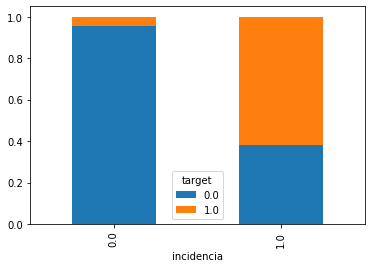

In [361]:
table=pd.crosstab(data_dic.incidencia,data_dic.target)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

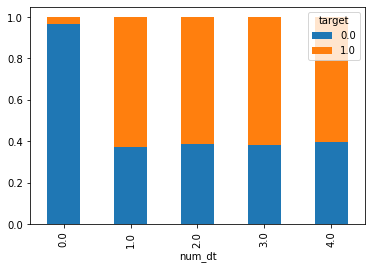

In [362]:
table=pd.crosstab(data_dic.num_dt,data_dic.target)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

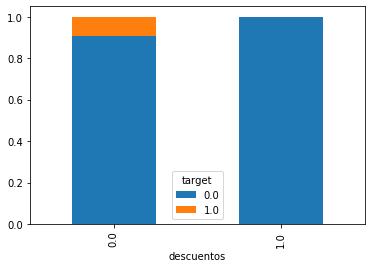

In [363]:
table=pd.crosstab(data_dic.descuentos,data_dic.target)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

# Modelo de clasificación

### (a) Primera aproximación: regresión logística.
La aproximación inicial al ejercicio será a través de una regresión logística. La regresión logística es un tipo de modelo lineal generalizado (*GLM*), que a diferencia de la regresión lineal -que premite predecir un valor objetivo o target-, utiliza la función logit como función de enlace para predecir ya no un valor sino **la probabilidad de evento frente a la probabilidad de no evento**. La función o transformación logit, sabemos, se utiliza como *enlace* para restringir los valores de la predicción al intervalo 0 - 1 (que es el intervalo compatible con el concepto de probabilidad). Otras funciones de distribución que son utilizadas como enlace son la distribución normal y la distribución gumbel. Dada su mayor facilidad de interpretación, la función logit es más utilizada.

A partir de la **matriz de confusión**, la regresión logística (y todos los modelos de clasificación en general -usaremos los mismos más tarde) tiene cinco criterios de evaluación bastante generalizados (hay más, que describiremos más tarde cuando identifiquemos el mejor modelo logit):

+ **accuracy** o validez: en modelos supervisados (en que conocemos la *realidad*), describe la capacidad que tiene el modelo para que sus predicciones coincidan los valores observados o reales. Dicho de otra forma, mide la bondad de un modelo de clasificación como la proporción de resultados verdaderos con respecto al total de casos.
+ **precision** o precisión: describe la capacidad que tiene el modelo para que sus predicciones coincidan con la ocurrencia del evento. Es decir, es la proporción de resultados verdaderos sobre todos los resultados positivos.
+ **recall** o exhaustividad: es la fracción de todos los resultados correctos devueltos por el modelo.
+ **F1** o valor-F: se calcula como el promedio ponderado de *precision* y *recall* entre 0 y 1, donde el valor ideal de puntaje F es 1.
+ **Curva ROC y AUC**: mide el área bajo la curva trazada con positivos verdaderos en el eje y, y falsos positivos en el eje x. Esta métrica es útil porque proporciona un número único que permite comparar modelos de diferentes tipos.


**Nota:** El escalado o normalización de las variables a introducir en el modelo no es una exigencia, pero por algún motivo la función `LogisticRegression` de `sklearn` no puede con este conjunto de datos sin escalado (incluso, sugiere llevar a cabo ese procedimiento).

In [364]:
# Dividimos target de features
target = data_dic['target']
features = data_dic[['edad', 'facturacion', 'provincia', 'num_lineas', 'num_dt',
       'incidencia', 'conexion', 'vel_conexion', 'num_llamad_ent',
       'num_llamad_sal', 'mb_datos', 'seg_llamad_ent', 'seg_llamad_sal',
       'financiacion', 'imp_financ', 'descuentos', 'ano_alta', 'mes_alta',
       'dia_alta', 'fidelidad', 'tv_familiar', 'tv_futbol']] 

In [365]:
# Escalado de features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, columns = features.columns)

In [366]:
scaled_features.head()

,edad,facturacion,provincia,num_lineas,num_dt,incidencia,conexion,vel_conexion,num_llamad_ent,num_llamad_sal,...,seg_llamad_sal,financiacion,imp_financ,descuentos,ano_alta,mes_alta,dia_alta,fidelidad,tv_familiar,tv_futbol
0,0.588947,0.077555,-0.105468,1.327223,-0.245439,-0.240794,1.003494,-0.482585,-0.204376,0.995106,...,0.645657,-0.267431,-0.241745,-0.500992,1.532232,1.300006,0.499769,-1.585483,-0.739799,1.004167
1,1.660882,0.435034,1.416713,-0.514247,-0.245439,-0.240794,1.003494,2.585261,0.885400,1.338515,...,0.144398,-0.267431,-0.241745,1.996041,1.393240,0.428963,-1.002054,-1.411365,-0.739799,1.004167
2,0.742081,-0.643281,-1.696840,0.406488,-0.245439,-0.240794,-0.996518,-0.566253,0.057722,-0.687601,...,1.164787,-0.267431,-0.241745,1.996041,-0.830640,1.590353,-0.000839,0.762062,-0.739799,1.004167
3,0.895214,0.433486,0.102102,0.406488,-0.245439,-0.240794,1.003494,0.354100,-1.018260,0.067900,...,-0.565415,-0.267431,-0.241745,-0.500992,1.115255,0.428963,1.000376,-1.128139,1.351719,-0.995850
4,-1.350744,-1.662343,1.070763,-1.434982,2.633107,-0.240794,-0.996518,-0.705701,0.802632,-1.614806,...,-0.962050,-0.267431,-0.241745,-0.500992,-1.386609,0.428963,0.499769,1.363109,-0.739799,1.004167


In [367]:
# Creamos los conjuntos de datos de train y test, con datos escalados.
X_train, X_test, y_train, y_test = train_test_split(scaled_features,
                                                    target,
                                                    test_size=0.3,
                                                    stratify = target)

### Modelo logit 1 (todas las variables)

In [368]:
# Entrenamos nuestro modelo base de regresión
mod_logit_base = LogisticRegression().fit(X_train, y_train)
# Construimos la predicción con el modelo 1
y_pred_logit = mod_logit_base.predict(X_test)

In [369]:
# Definimos función para explorar las métricas de los modelos.
def saca_metricas(y1, y2):
    print('Matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('Accuracy')
    print(accuracy_score(y1, y2))
    print('Precision')
    print(precision_score(y1, y2))
    print('Recall')
    print(recall_score(y1, y2))
    print('F1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)

##### El modelo que hemos llamado "base" es ciertamente bastante bueno. Con un proceso de depuración básico y un feature engineering sencillo (creación de dummies) el modelo obtiene una validez o **accuracy** de 97,4%, y un **área bajo la curva (AUC)** de 91,9%. 

##### Luego, si observamos la importancia de las variables en este modelo, vemos que sólo 5 aportan información (ya lo veíamos antes con en EDA): `num_dt`, `incidencia`, `financiacion`, `imp_financ` y `descuentos`. Ahora, sabemos que `descuentos` tiene una importancia desproporcionada. De hecho, el modelo probablemente sufra sesgos con esta variable, pues todos sus valores 1 (que cliente tiene descuento) serán interpretado como ausencia de evento `target`. Vamos a construir un segundo modelo sin `descuento`, con las otras cuatro variables, y evaluar si obtenemos un modelo igual de bueno pero más sencillo.

Matriz de confusión
[[26122   393]
 [  309  1817]]
Accuracy
0.9754896826228134
Precision
0.8221719457013574
Recall
0.8546566321730951
F1
0.8380996309963099
AUC
0.9199174165956933


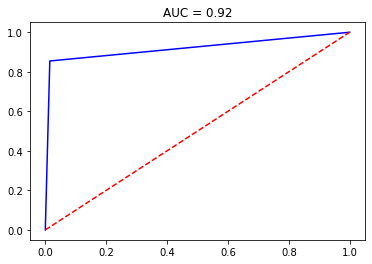

In [370]:
# Inspección:
saca_metricas(y_test, y_pred_logit)

Feature: 0, Score: 0.01428
Feature: 1, Score: 0.00020
Feature: 2, Score: 0.00255
Feature: 3, Score: 0.02100
Feature: 4, Score: 1.58566
Feature: 5, Score: 1.31401
Feature: 6, Score: -0.01337
Feature: 7, Score: 0.02108
Feature: 8, Score: 0.08212
Feature: 9, Score: 0.00079
Feature: 10, Score: 0.02265
Feature: 11, Score: 0.03384
Feature: 12, Score: -0.03546
Feature: 13, Score: -1.41189
Feature: 14, Score: -0.72273
Feature: 15, Score: -4.39976
Feature: 16, Score: 0.01186
Feature: 17, Score: -0.02671
Feature: 18, Score: 0.02734
Feature: 19, Score: -0.00859
Feature: 20, Score: -0.07255
Feature: 21, Score: -0.05089


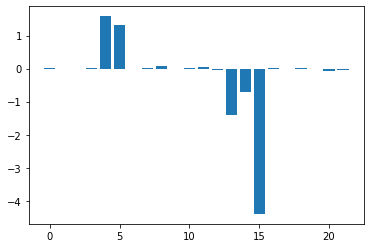

In [371]:
# Importancia de los features
var_logit_importance = mod_logit_base.coef_[0]

# Agrupar importancia
for i,v in enumerate(var_logit_importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# Graficamos la importancia de variables.
pyplot.bar([x for x in range(len(var_logit_importance))], var_logit_importance)
pyplot.show()

### Modelo logit 2 (sólo 4 variables)

Entrenaremos un modelo con las 4 variables más importantes, quitando `descuentos`. La idea es probar si este modelo sigue siendo tan bueno como el base, pero con menos parámetros, y quitando una variable que era demasiado importante pero que estaba muy mal distribuida entre la `target` (no tiene registros entre los no-`target` o que no se van de la compañía).

In [372]:
# Entrenar modelo con 4 variables
mod_logit_min = LogisticRegression().fit(X_train[['num_dt','incidencia','financiacion','imp_financ']], y_train)

# Construir predicción
y_pred_logit2 = mod_logit_min.predict(X_test[['num_dt','incidencia','financiacion','imp_financ']])

##### El modelo más sencillo es bastante aceptable. Sigue teniendo un **accuracy** elevado (95%) pero pierde bastante capacidad de identificar eventos (AUC 84%) y baja bastante el valor F1. Por lo tanto, construiremos un tercer modelo con `descuentos`, pues 5 variables tampoco es excesivo.

Matriz de confusión
[[25728   787]
 [  569  1557]]
Accuracy
0.9526552843825286
Precision
0.6642491467576792
Recall
0.7323612417685795
F1
0.6966442953020134
AUC
0.8513399646519684


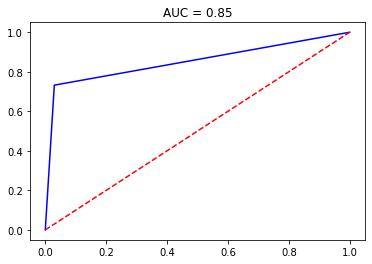

In [373]:
# Inspección:
saca_metricas(y_test, y_pred_logit2)

Feature: 0, Score: 1.16000
Feature: 1, Score: 1.10957
Feature: 2, Score: -1.07386
Feature: 3, Score: -0.50939


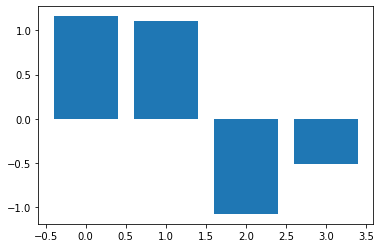

In [374]:
# Importancia de los features
var_logit_importance2 = mod_logit_min.coef_[0]

# Agrupar importancia
for i,v in enumerate(var_logit_importance2):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# Graficamos la importancia de variables.
pyplot.bar([x for x in range(len(var_logit_importance2))], var_logit_importance2)
pyplot.show()

### Modelo logit3 (anterior más `descuentos`)

En este tercer modelo volvemos a incorporar la variable `descuentos`, que tiene bastante importancia para predecir la probabilidad de ocurrencia del fenómeno.

In [375]:
# Entrenamos el modelo
mod_logit_3 = LogisticRegression().fit(X_train[['num_dt','incidencia','financiacion','imp_financ','descuentos']], y_train)

# Construimos la predicción
y_pred_logit3 = mod_logit_3.predict(X_test[['num_dt','incidencia','financiacion','imp_financ','descuentos']])

##### Finalmente, con las 5 variables retomamos un **accuracy** de 97,4% y una probabilidad de predecir evento de 91,9%. Este modelo nos gusta más. Vamos a dejar este modelo como base, para luego tratar de mejorarlo a través de un feature engineering y de alteración de hiperparámetros. 

Matriz de confusión
[[26121   394]
 [  307  1819]]
Accuracy
0.9755245976048322
Precision
0.8219611387257117
Recall
0.8555973659454374
F1
0.8384420373357917
AUC
0.9203689262312515


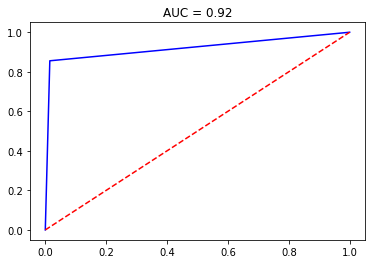

In [376]:
# Inspección:
saca_metricas(y_test, y_pred_logit3)

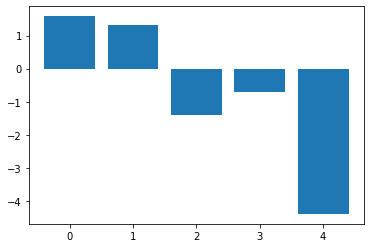

In [377]:
# Importancia de los features
var_logit_importance3 = mod_logit_3.coef_[0]

# Agrupar importancia
for i,v in enumerate(var_logit_importance3):
    ('Feature: %0d, Score: %.5f' % (i,v))
    
# Graficamos la importancia de variables.
pyplot.bar([x for x in range(len(var_logit_importance3))], var_logit_importance3)
pyplot.show()

### (b) Segunda aproximación: random forest.
Luego, con el mismo conjunto de datos (*ahora no escalados, este algoritmo no lo necesita*), probaremos un modelo de clasificación a través de *random forest*.

Literatura consultada: **Árboles de decisión y Random Forest (Johanna Orellana Alvear)** -https://bookdown.org/content/2031/

*Random Forest* son simplemente una combinación de árboles de decisión. Los árboles de decisión (*decision trees*) son un tipo de algoritmo de aprendizaje supervisado principalmente utilizado para problemas de clasificación, pues se caracteriza por dividir el espacio de features (o predictores) en regiones distintas y no sobrepuestas. Estos algoritmos son populares porque puede trabajar indistintamente con variables categóricas o contínuas, y porque son relativamente fáciles de explicar/comunicar.

Como decíamos, el *random forest* es una combinación o **ensamble** de *decision trees* que a través de *bagging* o creación de subconjuntos de datos para crear múltiples modelos y luego combinarlos.

Los criterios de valuación genearles de un modelo de este tipo son los mismos descritos para los modelos de regresión logística (**accuracy, precision, recall, F1, y AUC**).

Para este modelo creamos un nuevo muestreo, con datos no escalados, manteniendo la estratificación según la `target`. 

In [378]:
# Creamos los conjuntos de datos de train y test, no escalado
X_train2, X_test2, y_train2, y_test2 = train_test_split(features,
                                                        target,
                                                        test_size = 0.3,
                                                        stratify = target)

### Modelo random forest 1 (todas las variables)

**Nota**: Al ser árboles aleatorios ensamblados, los valores de los parámetros pueden cambiar levemente respecto a los descritos en el documento.

In [379]:
# Entrenamos el modelo con datos train
mod_rforest = RandomForestClassifier().fit(X_train2, y_train2)

# Creamos la predicción
y_pred_rf = mod_rforest.predict(X_test2)

A través de un *random forest*, de 28.641 datos en test el modelo falla sólo 510, es decir, el 1,8%. Dicho de otra forma, el modelo tiene un **accuracy de 98,3%, y AUC de 98,9%**. El modelo está muy bien, pero en una nueva iteración trataremos de reducir el número de dimensiones según su importancia.

Matriz de confusión
[[26017   498]
 [    6  2120]]
Accuracy
0.9824028490625327
Precision
0.8097784568372803
Recall
0.9971777986829727
F1
0.8937605396290051
AUC
0.9891979885362818


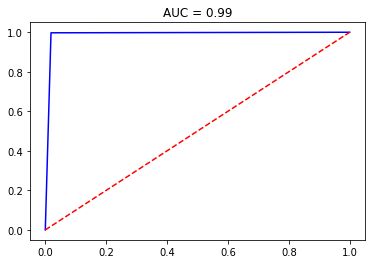

In [380]:
# Inspección:
saca_metricas(y_test2, y_pred_rf)

Feature: 0, Score: 0.01573
Feature: 1, Score: 0.02016
Feature: 2, Score: 0.01544
Feature: 3, Score: 0.00634
Feature: 4, Score: 0.36259
Feature: 5, Score: 0.30036
Feature: 6, Score: 0.00211
Feature: 7, Score: 0.00997
Feature: 8, Score: 0.01897
Feature: 9, Score: 0.01688
Feature: 10, Score: 0.01979
Feature: 11, Score: 0.01945
Feature: 12, Score: 0.02051
Feature: 13, Score: 0.01016
Feature: 14, Score: 0.01407
Feature: 15, Score: 0.09266
Feature: 16, Score: 0.01111
Feature: 17, Score: 0.01121
Feature: 18, Score: 0.00880
Feature: 19, Score: 0.01859
Feature: 20, Score: 0.00241
Feature: 21, Score: 0.00270


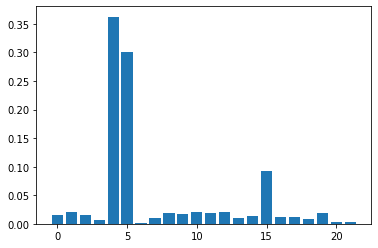

In [381]:
# Construimos importancia de los descriptores
var_importance_forest = mod_rforest.feature_importances_

# Agrupamos la importancia
for i,v in enumerate(var_importance_forest):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# Graficamos la importancia de variables.
pyplot.bar([x for x in range(len(var_importance_forest))], var_importance_forest)
pyplot.show()

### Modelo random forest 2 (3 variables más importantes)

Para el modelo completo a través de *random forest* las variables más importantes son `num_dt`, `incidencia` y `descuentos`. Vamos a inspeccionar un modelo *random forest* con solo estas tres.

In [382]:
# Entrenamos el modelo con datos train
mod_rforest_2 = RandomForestClassifier().fit(X_train2[['num_dt','incidencia','descuentos']], y_train2)

# Creamos la predicción
y_pred_rf2 = mod_rforest_2.predict(X_test2[['num_dt','incidencia','descuentos']])

<br>El modelo es perfectamente bueno con solo 3 variables. *Accuracy* y *AUC* muy buenos sin bajar mucho el f1. Además, sigue teniendo una capacidad de predecir evento cercana al 99%. Por tanto, nos quedamos con este modelo.

Matriz de confusión
[[25857   658]
 [    6  2120]]
Accuracy
0.9768164519395273
Precision
0.7631389488840893
Recall
0.9971777986829727
F1
0.8646003262642741
AUC
0.9861808284382241


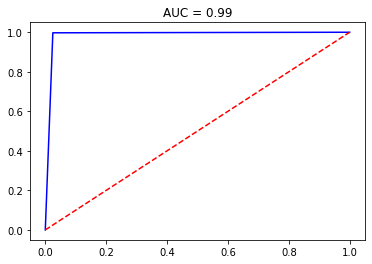

In [383]:
# Inspección:
saca_metricas(y_test2, y_pred_rf2)

Feature: 0, Score: 0.47693
Feature: 1, Score: 0.39157
Feature: 2, Score: 0.13150


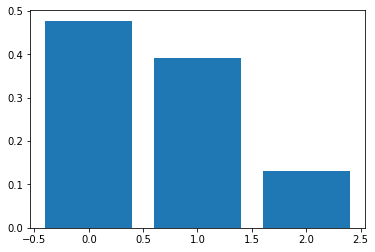

In [384]:
# Construimos importancia de los descriptores
var_importance_forest_2 = mod_rforest_2.feature_importances_

# Agrupamos la importancia
for i,v in enumerate(var_importance_forest_2):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# Graficamos la importancia de variables.
pyplot.bar([x for x in range(len(var_importance_forest_2))], var_importance_forest_2)
pyplot.show()

# Feature engineering

En la práctica, los modelos de *random forest* no son mejorables (ya son suficientemente buenos). Quizás podrían transformarse alguna de las 3 variables implicadas en el modelo `mod_rforest_2` para mantener su accuracy disminuyendo aun más el número de features, pero teniendo solo 3 no parece razonable. Además, disminuyendo tanto la cantidad de features la utilización de *random forest* pierde su sentido. Por lo tanto, en este apartado trataremos de mejorar nuestro modelo logit. Para ello realizaremos algunas transformaciones en los datos de diciembre, y alteraremos hiperparámetros.

### (a) Creación de variables.
En este primer subapartado de feature engineering vamos a crear variables nuevas con interacciones de los datos original. Veremos si alguna operación de este tipo permite entregar más información al modelo respecto a la `target` -adelantamos que no.

Lo que se tiene es que, en general, las variables que han quedado fuera del modelo logit 3 no aportan al modelo. Así, por ejemplo, ni la `edad`, ni el número de llamadas entrantes (`num_llamad_ent`), ni los segundos de las llamadas entrantes (`seg_llamad_ent`), ni los megas de datos contratados (`mb_datos`) permiten distinguir entre clientes que permanecen y que se van.

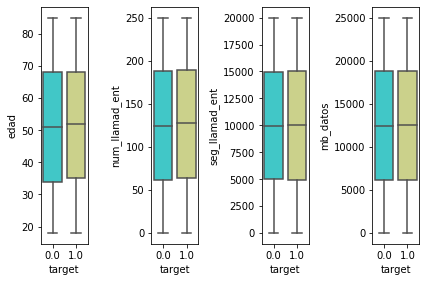

In [385]:
figure, axes = plt.subplots(nrows=1, ncols=4)
plt.subplot(1, 4, 1)
sns.boxplot(x='target', y='edad', data=data_dic, palette='rainbow')
plt.subplot(1, 4, 2)
sns.boxplot(x='target', y='num_llamad_ent', data=data_dic, palette='rainbow')
plt.subplot(1, 4, 3)
sns.boxplot(x='target', y='seg_llamad_ent', data=data_dic, palette='rainbow')
plt.subplot(1, 4, 4)
sns.boxplot(x='target', y='mb_datos', data=data_dic, palette='rainbow')
figure.tight_layout(pad=1)

<br>Incluso combinándolas, no sirven. Hemos creado algunas variables con asociaciones de features de diciembre, que tampoco aportan información. Por ejemplo, el neto de número de llamadas (restando entrantes menos salientes); el neto de segundos de llamadas (restando los segundos de llamadas entrantes menos salientes); o creando una especie de índice de uso de servicios (multiplicando los segundos de llamadas salientes por los megas contratados): ninguna de estas variables permite discriminar respecto a la `target`.

No seguiremos por este camino. En general, y salvo las vaiables usadas para los modelos antes descritos, los features del conjunto de datos aportan tan poca información a la hora de predecir la fuga de clientes que no merece la pena seguir por ahí. Vamos a tratar de incorporar información externa.

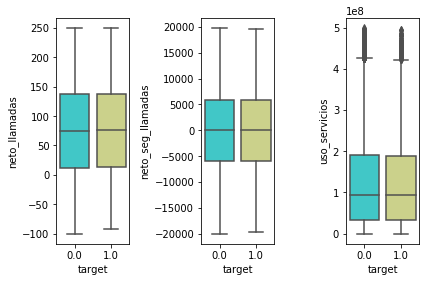

In [386]:
data_dic['neto_llamadas'] = data_dic['num_llamad_ent'] - data_dic['num_llamad_sal']
data_dic['neto_seg_llamadas'] = data_dic['seg_llamad_ent'] - data_dic['seg_llamad_sal']
data_dic['uso_servicios'] = data_dic['seg_llamad_ent'] * data_dic['mb_datos']

figure, axes = plt.subplots(nrows=1, ncols=3)
plt.subplot(1, 3, 1)
sns.boxplot(x='target', y='neto_llamadas', data=data_dic, palette='rainbow')
plt.subplot(1, 3, 2)
sns.boxplot(x='target', y='neto_seg_llamadas', data=data_dic, palette='rainbow')
plt.subplot(1, 3, 3)
sns.boxplot(x='target', y='uso_servicios', data=data_dic, palette='rainbow')
figure.tight_layout(pad=1)

¿Mejoraría si en vez de crear variables, tratamos de tramificarlas o incorporar información externa al dataset para mejorar las variables? Parece que no. Por ejemplo, la variable `provincia`, que en potencia podría aportar información sumando datos externos (PIB -indirectamente, poder de compra de residentes-, o tamaño de la población) en realidad aporta muy poco, (i) porque hay relativamente la misma cantidad de clientes en cada provincia (en torno a 1900. Por tanto no podemos, por ejemplo, dividirlas entre "provincias con más o menos clientes"), y lo más importante, (ii) porque ninguna de las provincias tiene una distribución de clientes que se quedan o se van significativamente distinta al resto. 

In [387]:
from collections import Counter
Counter(dic_raw['provincia']).values() # frecuencia de aparición

dict_values([1877, 1838, 1889, 1871, 1913, 1924, 1879, 1921, 1954, 1907, 1949, 1860, 1909, 1913, 1931, 1914, 1860, 1939, 1898, 1986, 1936, 1972, 1973, 1928, 1831, 1902, 1888, 1855, 1900, 1912, 1905, 1898, 1907, 1917, 1972, 1899, 1932, 1945, 1958, 1853, 1991, 1967, 1851, 1869, 1881, 1893, 1922, 1915, 1864, 1899])

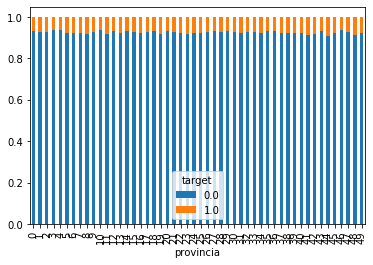

In [388]:
table=pd.crosstab(data_dic.provincia,data_dic.target)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

### (b) Transformación de variables

Probemos, finalmente, trabajando sobre las 5 variables involucradas en el modelo logit: `num_dt`, `incidencia`, `financiacion`, `descuentos` y `imp_financ`. De ellas, realmente podemos transformar `num_dt` y `imp_financ`, pues las otras ya son dicotómicas. Probaremos, entonces, transformando estas dos a dicotómicas.

In [389]:
# Transformamos a dicotómicas
data_dic['num_dt'].replace((1,2,3,4), (1), inplace=True)
data_dic['imp_financ'] = data_dic['imp_financ'].apply(lambda x: 1 if x>1 else 0)

In [390]:
# Luego creamos un dataset de features con sólo las 5 variables.
target = data_dic['target']
fe_features = data_dic[['num_dt','incidencia','financiacion','imp_financ','descuentos']]

In [391]:
# Creamos los conjuntos de datos de train y test.
# Al ser todas variables dicotómicas 0 / 1, no necesitamos escalarlas.
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(fe_features,
                                                    target,
                                                    test_size=0.3,
                                                    stratify = target)

In [392]:
# Entrenamos nuestro modelo base de regresión
mod_logit_fe = LogisticRegression().fit(X_train_fe, y_train_fe)

# Construimos la predicción con el modelo "fe"
y_pred_logit_fe = mod_logit_fe.predict(X_test_fe)

<br>Con estas transformaciones hemos mejorado sustantivamente al modelo. La diferencia entre los valores en `num_dt` no aportaba información adicional, pues lo que más discriminaba era el hecho de que se tuvieran o no líneas en impago. De igual forma, el importe/cantidad que se paga por terminales financiados es irrelevante (`imp_financ`), pues lo que más importa para el modelo es el hecho de que se esté pagando algo (valor 1), versus que no se esté pagando nada (valor 0).

Con todo, mejoramos en *accuracy*, en capacidad de identificar eventos "fuga" y en F1. Es en el sentido del AUC, incluso levemente mejor al modelo *random forest*. Además, al no tener variables escaladas en este modelo logit (solo dicotómicas), es mucho más fácil de comunicar. Veremos todo esto en el apartado de predicción.

Matriz de confusión
[[26065   450]
 [   14  2112]]
Accuracy
0.9837994483432841
Precision
0.8243559718969555
Recall
0.993414863593603
F1
0.901023890784983
AUC
0.9882216690210142


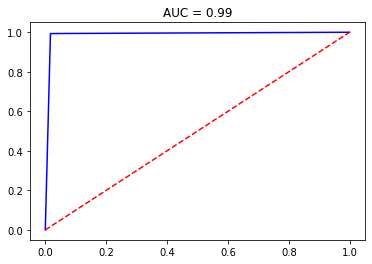

In [393]:
# Inspección:
saca_metricas(y_test_fe, y_pred_logit_fe)

Feature: 0, Score: 7.45270
Feature: 1, Score: 7.46372
Feature: 2, Score: -3.65443
Feature: 3, Score: -3.65443
Feature: 4, Score: -9.59193


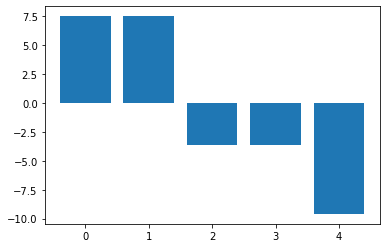

In [394]:
# Importancia de los features
var_logit_importance_fe = mod_logit_fe.coef_[0]

# Agrupar importancia
for i,v in enumerate(var_logit_importance_fe):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# Graficamos la importancia de variables.
pyplot.bar([x for x in range(len(var_logit_importance_fe))], var_logit_importance_fe)
pyplot.show()

### (c) Control de hiperparámetros

En este subapartado de feature engineering o mejora de modelo, jugaremos un poco con los hiperparámetros de la regresión logística. La verdad es que el modelo ya es suficientemente bueno, pero con objeto de completar el ejercicio probaremos un poco con ello.

La función de regresión logística de `sklearn` proporciona los siguientes hiperparámetros para mejorar el ajuste del modelo:

> Fuente: https://medium.com/@rubialesalberto/regresi%C3%B3n-log%C3%ADstica-con-sklearn-4384c707075d

+ **fit_intercept**: puede ser True/false si queremos tener una constante β₀ o no
+ **penalty**: es la regularización, hay distintos tipos:
    - L1: hace que algunas β sean 0.
    - L2: también conocida como Ridge, lo que hace es estimar β pequeños, sirve para controlar el sobre ajuste.
    - elasticnet: sirve para aplicar la regularización L1 y L2 a la vez.
+ **tol**: es un parámetro que se encuentra dentro de los llamados “early stopping”. Es para que una vez alcanzado el criterio de tolerancia que nosotros fijemos, el algoritmo pare de iterar.
+ **C**: un parámetro que aplica regularización con el objetivo de reducir el overfitting, cuanto más pequeño es el valor, mayor es la regularización.
+ **class_weight**: puede ser balanced/None dependiendo de si quieres balancear tu conjunto de datos o no, si tienes clases desbalanceadas.
+ **solver**: Es el algoritmo encargado de resolver el problema de clasificiación.
+ **multi_class**: puede ser ovr/multinomial/auto en el caso de que tengamos un problema de clasificación. Es la estrategia a seguir para resolver dicho problema.
+ **warm_start**: puede ser True/False. Es usado para reducir el tiempo de procesamiento del kernel en los casos en los que trabajamos con grandes datasets. Solo sirve para los kernels lbfgs, newton-cg y saga.
+ **l1_ratio**: en el caso de que escojamos la regularización (penalty) “elasticnet”, indicamos el porcentaje de regularización l1 y l2, si lo fijamos en 0 aplicamos solo la regularización l2, si lo fijamos en 1 aplicamos la regularización l1 por completo.

---
#### La verdad es que el modelo tenía muy poco margen para mejorar. La modificación de hiperparámetros mejoró insignificantemente el modelo.

In [395]:
# Entrenamos nuestro modelo base de regresión
mod_logit_hp = LogisticRegression(penalty='l2', C=0.7, solver='lbfgs', fit_intercept=False).fit(X_train_fe, y_train_fe)

# Construimos la predicción con el modelo "fe"
y_pred_logit_hp = mod_logit_hp.predict(X_test_fe)

Matriz de confusión
[[26071   444]
 [   14  2112]]
Accuracy
0.9840089382353968
Precision
0.8262910798122066
Recall
0.993414863593603
F1
0.9021785561725758
AUC
0.9883348125246912


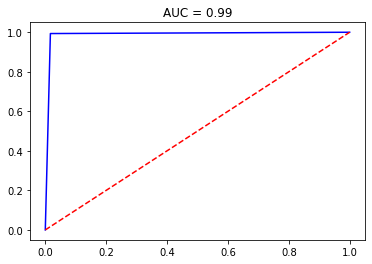

In [396]:
# Inspección:
saca_metricas(y_test_fe, y_pred_logit_hp)

### (d) Validación cruzada

Concluyendo este apartado, realizaremos una validación cruzada de los modelos (logit que hemos mejorado a través de feature engineering, e hiperparámetros; y el *random forest* 2). La validación cruzada, sabemos, es una **técnica para evaluar la estabilidad del modelo garantizando que sus métricas/parámetros son independientes de la partición de datos que hacemos en el muestreo**. Consiste, simplemente, en calcular las metricas para distintos subconjuntos de datos y evaluar su estabilidad.

#### (1) Modelo logit
Así, para 10 subconjuntos de datos, se tiene:
+ En train, una media de **accuracy** de 98,4% con **desviación** 0.0010 (ínfima!)
+ En test, una media de **accuracy** de 98,2% con **desviación** 0.0018 (ínfima también!)

##### En conclusión, el modelo logit es bastante estable, y no produce *overfitting* (sus datos funcionan igualmente bien en test).

In [397]:
# Hacemos la validación con 10 subconjuntos.
vc_train = cross_val_score(estimator=mod_logit_hp, X=X_train_fe, y=y_train_fe, cv=10)

In [398]:
# Media de accuracy
vc_train.mean()

0.9836291545157645

In [399]:
# Desviación
vc_train.std()

0.0021077411479217914

In [400]:
# Hacemos la validación con 10 subconjuntos.
vc_test = cross_val_score(estimator=mod_logit_hp, X=X_test_fe, y=y_test_fe, cv=10)

In [401]:
# Media de accuracy
vc_test.mean()

0.9840088308130295

In [402]:
# Desviación
vc_test.std()

0.0022407047207367516

#### (2) Modelo random forest
También para 10 subconjuntos de datos, se tiene:
+ En train, una media de **accuracy** de 98,4% con **desviación** 0.0010 (ínfima!)
+ En test, una media de **accuracy** de 98,2% con **desviación** 0.0018 (ínfima también!)

##### En conclusión, el modelo random forest también es bastante estable y sin *overfitting*. De hecho, estas metricas son exactamente iguales!

In [403]:
# Hacemos la validación con 10 subconjuntos.
vc_train_rf = cross_val_score(estimator=mod_rforest_2, X=X_train_fe, y=y_train_fe, cv=10)

In [404]:
# Media de accuracy
vc_train.mean()

0.9836291545157645

In [405]:
# Desviación
vc_train.std()

0.0021077411479217914

In [406]:
# Hacemos la validación con 10 subconjuntos.
vc_test = cross_val_score(estimator=mod_rforest_2, X=X_test_fe, y=y_test_fe, cv=10)

In [407]:
# Media de accuracy
vc_test.mean()

0.9840088308130295

In [408]:
# Desviación
vc_test.std()

0.0022407047207367516

## Conclusiones respecto a los modelos.

Contamos con dos modelos. El mejor de ellos en términos de capacidad predictiva es el logit con 5 variables **¡pero muy marginalmente! (98,68% vs. 98,66% de AUC)**. Podemos decir entonces que en ese sentido son prácticamente iguales: similar capacidad predictiva, ninguno produce *overfitting*, son ambos bastante estables, etc. Por lo tanto, lo que determina el modelo ganador será el número de variables: *random forest* está por sobre el logit con solo 3 features.

En suma: A través de un feature engineering bastante sencillo hemos mejorado el modelo logit. No obstante, el *random forest* es mejor por parsinomía. Además, a lo largo de todo este ejercicio hemos mostardo por qué hay 3 - 5 variables determinantes a la hora de clasificar a los clientes, y por qué el resto de variables son inutiles en términos de la información que podrían aportar a modelos.

Llegados a este punto no realizaremos más ajustes al conjunto de datos ni probaremos con otros algoritmos, sencillamente porque ya tenemos un par bastante buenos. Pasaremos a la etapa de "producción" para predecir cuántos clientes dejarían la compañía en febrero de 2020.

# Predicción e interpretación del modelo

En este último apartado del ejercicio, realizaremos la predicción de clientes de enero que potencialmente dejarán la compañía en febrero, según el modelo ganador (*random forest*). Describiremos, además, los coeficientes de cada uno de ellos, interpretandolos en términos de una estrategia de negocios. Finalmente, revisaremos las predicciones.

Antes de comenzar, cabe destacar que para poder utilizar los modelos que hemos construido sobre el conjunto de datos de enero, debemos realizar las mismas transformaciones que hemos realizar sobre los datos de diciembre. Esto lo haremos rápidamente, y sin mayor descripción (está antes).

**Nota:** Una alternativa habría sido juntar los datos de diciembre y enero, incorporando una etiqueta que permita diferenciarlos, y aplicar las transformaciones solo 1 vez sobre todos los registros. 

In [409]:
# Incongruencias de Nan
ene_raw['num_dt'].fillna(0, inplace=True)
ene_raw['imp_financ'].fillna(0, inplace=True)
ene_raw['incidencia'].replace(('SI'), (1), inplace=True)
ene_raw['incidencia'].fillna(0, inplace=True)
ene_raw['financiacion'].replace(('SI'), (1), inplace=True)
ene_raw['financiacion'].fillna(0, inplace=True)
ene_raw['descuentos'].replace(('SI'), (1), inplace=True)
ene_raw['descuentos'].fillna(0, inplace=True)

In [410]:
# Le damos formato fecha a la columna `antiguedad`
ene_raw['antiguedad'] = pd.to_datetime(ene_raw['antiguedad'], format='%m/%d/%Y %I:%M %p')
# Creamos variables numéricas del año, mes y día de la semana en que se ha dado de alta el cliente
ene_raw['ano_alta'] = ene_raw['antiguedad'].dt.year
ene_raw['mes_alta'] = ene_raw['antiguedad'].dt.month
ene_raw['dia_alta'] = ene_raw['antiguedad'].dt.dayofweek

In [411]:
# Creamos el día de referencia para calcular antiguedad en días (1 de enero de 2020)
age = pd.to_datetime('2020-01-01')

In [412]:
# Calculamos la diferencia
dif = age - ene_raw['antiguedad']

In [413]:
# Extraémos solos los días en una nueva variable
ene_raw['fidelidad'] = dif.dt.days

In [414]:
# Provincias
ene_raw['provincia'] = ene_raw['provincia'].astype('category')
ene_raw['provincia'] = ene_raw['provincia'].cat.codes

In [415]:
# Numerica escondida
ene_raw['conexion'].replace(('FIBRA','ADSL'), (1,0), inplace=True)

In [416]:
ene_raw['vel_conexion'] = ene_raw['vel_conexion'].str.strip('MB')
ene_raw['vel_conexion'] = ene_raw['vel_conexion'].astype('int32')

In [417]:
# Creo dummies
tv_dummies = pd.get_dummies(ene_raw['TV'])
ene_raw.insert(19, 'tv_familiar', tv_dummies['tv-familiar'])
ene_raw.insert(20, 'tv_futbol', tv_dummies['tv-futbol'])

In [418]:
# Clasificación de clientes de enero.
pred_rf_ene = mod_rforest_2.predict(features_ene[['num_dt','incidencia','descuentos']])

In [419]:
features_ene = ene_raw[['edad', 'facturacion', 'provincia', 'num_lineas', 'num_dt',
       'incidencia', 'conexion', 'vel_conexion', 'num_llamad_ent',
       'num_llamad_sal', 'mb_datos', 'seg_llamad_ent', 'seg_llamad_sal',
       'financiacion', 'imp_financ', 'descuentos', 'ano_alta', 'mes_alta',
       'dia_alta', 'fidelidad', 'tv_familiar', 'tv_futbol']]

## Predicción a través de modelo *random forest* con 3 variables.

Recordemos que este modelo tiene la mejor capacidad predictiva de evento de **98,66% AUC**. Además, recordemos que **la cantidad de clientes que dejaron la compañía en enero respecto a diciembre fue del 7,4%** (cualquier valor muy distinto a él habría que mirarlo con cuidado).

Pasemos a revisar: 
+ Primero, si hacemos directamente la predicción/clasificación de fugar da cada cliente de enero, observamos que 2.137 se irán y 90.547 se quedarán en la compañía. Esto representa solo un 2,3% de sus clientes de enero, mostrando una baja significativa respecto al período anterior.
+ Luego, si miramos la probabilidad de fuga o score de cada cliente vemos que no hay puntos medios, y que en la práctica hay dos grupos de clientes:
    - (a) clientes con **baja probabilidad de abandonar** la compañía (probabilidad inferior al 0.01%).
    - (b) clientes con **alta probabilidad de dejar** la compañía (probabilidades sobre el 70%).

El histograma ulterior confirma visualmente que hay dos grupos. Y es más, estos dos grupos son tan homogéneos (es decir, que simplemente hay clientes con baja y alta probabilidad de dejar la compañía, sin matices), que para la empresa no merece la pena segmentar a los clientes para buscar retenerlos: hay que ir por todos ellos indistintamente.

In [420]:
pd.value_counts(pred_rf_ene)
# fuga: 2,3%

0.0    90574
1.0     2137
dtype: int64

In [421]:
prob_sujetos = mod_rforest_2.predict_proba(features_ene[['num_dt','incidencia','descuentos']])[:,1]
prob_sujetos = (pd.DataFrame(prob_sujetos, columns = ['Probabilidad'], index = features_ene[['num_dt','incidencia','descuentos']].index))
prob_sujetos.sort_values(by = ['Probabilidad'], ascending = False, axis = 0, inplace = True)

In [422]:
# Si quisiéramos ver las probabilidades ordenadas para establecer puntos de corte (para diferenciar estrategias).
proba_ordenada = pd.value_counts(prob_sujetos['Probabilidad'])
proba_ordenada = pd.DataFrame(proba_ordenada)
proba_ordenada['Real_proba'] = proba_ordenada.index.values
proba_ordenada.sort_values(by = ['Real_proba'], ascending = False, axis = 0, inplace = True)
proba_ordenada

,Probabilidad,Real_proba
0.798118,274,0.798118
0.785751,277,0.785751
0.784889,16,0.784889
0.779540,304,0.779540
0.775697,890,0.775697
0.765983,16,0.765983
0.746709,326,0.746709
0.727083,17,0.727083
0.719263,17,0.719263
0.000646,70536,0.000646


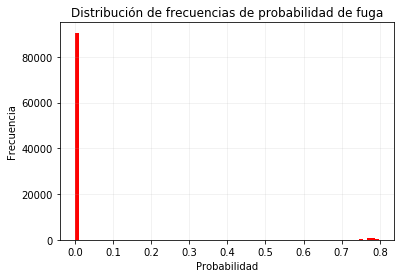

In [423]:
prob_sujetos.hist(bins=75, color='Red')
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.title('Distribución de frecuencias de probabilidad de fuga')
plt.grid(axis='both', alpha=0.2)
plt.show()

## Interpretación del modelo en clave de negocio

De acuerdo a este modelo de clasificación de potenciales clientes perdidos, la variable más importante es el hecho de **tener líneas en impago** (0.47/0.48
 de importancia). Le sigue el hecho de **registrar incidencias o reclamación** (0.39/0.40), y finalmente el **tener descuentos** (0.12/0.13).

In [428]:
# Importancia de las variables
mod_rforest_2.feature_importances_

array([0.47693199, 0.3915686 , 0.13149941])

Lo primero que llama la atención es la bajada en la proporción de clientes que dejarían la compañía en febrero respecto a los que lo hicieron en enero. En primer lugar, la compañía debe plantearse la necesidad de abordar una estrategia de retención de clientes, si dicha proporción de clientes fugaces es significativamente perjudicial para la empresa -en comparación, por ejemplo, a la cantidad de clientes que se dan de alta cada mes. Lo cierto es que la cantidad de clientes que se dan de alta cada mes ronda los 340-310, por lo que se aconsejaría sí hacerlo.

Ahora, 

+ Respecto al hecho de tener líneas en impago, vimos para los clientes de diciembre que la cantidad de líneas era indiferente: lo que importaba era el hecho de tener una o más líneas en impago. Recordemos que en este modelo no hemos transformado la variable, sigue siendo numérica (no dicotómica). Por tanto, siendo la variable más importante, sería pertinente sopesar los costos de mantener a clientes morosos contra los beneficios de retenerlo. Esa evaluación sobrepasa los objetivos de esta tarea, simplemente porque no contamos con información respecto al monto de morosidad para compararlo con, por ejemplo, la facturación mensual.

+ En segundo lugar, y con bastante importancia también, el hecho de registar una incidencia o reclamación es muy importante en este modelo a la hora de predecir la fuga de un cliente. Esta variable, aunque dicotómica (no una escala, por ejemplo) y sencilla es muy importante hoy en día en tiempos de consumidores empoderados e informados. En sectores como las telecomunicaciones (pero también otros servicios), donde la portabilidad está protegida por marcos legales e impulsadas por las propias compañías, los clientes guardan fidelidad hacia las compañías que sienten los tratan bien y respetan sus derechos. En este sentido, la compañía debe orientar sus esfuerzos en general a la satisfacción del cliente, y en particular a la resolución de problemas puntuales que -en todo contexto- emergerán tras la adquisición de un servicio.

+ Finalmente, sabemos tras nuestro EDA, que el hecho de tener descuento hace que un cliente **NO** deje la compañía. Esta variable no es la más importante, pero contando con solo 3, la compañía debe prestarle bastante atención también. Ahora bien, con esta información, y en estudios de otro tipo se tendría que indagar si este fenómeno ocurre por motivos objetivos o subjetivos: esto es, si los clientes con descuentos permanecen en la compañía porque objetivamente dicho descuento les ofrece tarifas más bajas que la competencia; o si, por el contrario, ocurre por la sensación subjetiva de sentirse beneficiado con una oportunidad brindada por la compañía. Si fuese lo primero, la compañía debe repensar y potenciar la estrategia de descuentos para convertirla en un motivo más poderoso de retención de clientes. Si fuese lo segundo, la compañía debería dinamizar y multiplicar (más pero de menos duración, por ejemplo) sus planes de descuento generando más espectativas entre sus clientes.

In [429]:
# número de clientes que se han dado de alta en DICIEMBRE 2019
dic_raw[(dic_raw.ano_alta == 2019) & (dic_raw.mes_alta == 12)].shape[0]

311

In [430]:
# número de clientes que se han dado de alta en NOVIEMBRE 2019
dic_raw[(dic_raw.ano_alta == 2019) & (dic_raw.mes_alta == 11)].shape[0]

319

In [431]:
# número de clientes que se han dado de alta en OCTUBRE 2019
dic_raw[(dic_raw.ano_alta == 2019) & (dic_raw.mes_alta == 10)].shape[0]

340

# Fin del ejercicio